# Introduction
# 
This notebook is the final delivery for the lecture "DataScience SS2020". 
This notebook was also used to participate in the following Kaggle Challenge on NLP ([LINK](https://www.kaggle.com/c/nlp-getting-started/overview)). 
The goal was the interpretation and analysis of the data, preprocessing and the creation of an NLP-ML-model and subsequent prediction. The model was then applied to a submission data set and submitted several times (after applying different models and hyperparameter optimizations).
The notebook was created directly in Kaggle and is therefore optimized to run in Kaggle.

**My Kaggle ID:** Benedikt Merkel

**My best Kaggle Score:** 0,84155


# Summary




**This notebook represents two notebooks in one:**

**The first part uses the following pre-trained BERT model:**

* bert_en_uncased_L-24_H-1024_A-16/2 [LINK](https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2)
* The process is accelerated by the GPU.



**The second part uses the following pre-trained BERT model:**

* DistilBERT
* bert-base-cased
* bert-large-cased
* bert-large-cased-whole-word-masking-finetuned-squad

(You can find the pretrained models here: [LINK](https://huggingface.co/transformers/pretrained_models.html))
The process was accelerated with the TCU.


# Summary

  
  
**Part 1: bert_en_uncased_L-24_H-1024_A-16/2**
*     Imports and check for accelerator unit
*     Import the Data 
*     Data Observation
*     Data Cleansing
*     Building the Model
*     Train the Model
*     Results Part 1
    
    
    
 **Part 2: bert-large-cased, and others**   
*     Imports and check for accelerator unit
*     Import the Data 
*     Data Observation
*     Data Cleansing
*     Building the Model
*     Hyperparameters
*     Train the Model
*     Results Part 2


 **Overall Conclusion**


# My general procedure

At first i tried to work with destilBERT as well as bert-base-cased, bert-large-cased, bert-large-cased-whole-word-masking-finetuned-squad and the TCU accelerator, which succeeded. Although the Accuracy, the Validation Accuracy and the Validation loss seemed better than in part 1, i could just achieve  akaggle score of max. 0.8271, even though i achieved better validation accuracies (0,88) and better validation losses (ca. 0,01). While i worked with the different pretrained models, i noticed that my score was approx. 0.01 points better with the large models than with the smaller counterpart.
Because of the experiance, i decided to go directly for the large model in part 1 instead of first trying the smaller one, like i did in the 2nd part (which was chronological the first). 

More details about the scores and parameters can be found under the respective parts.



  
   
# Inpirations:


* https://www.kaggle.com/raenish/cheatsheet-text-helper-functions
* https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers
* https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras/data
* https://www.kaggle.com/sagar7390/nlp-on-disaster-tweets-eda-glove-bert-using-tfhub*http://education.abcom.com/detecting-slang-using-bert/
* https://analyticsindiamag.com/tutorial-on-keras-callbacks-modelcheckpoint-and-earlystopping-in-deep-learning/
* https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub


# PART 1 (2nd in my chronological order but first in this notebook because i got the better keggle score with it.)



# IMPORTS AND CHECK FOR ACCELERATION UNIT

In [32]:
## import transformers (no need to install it, it's already included in kaggle)
import transformers

# original tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization

In [33]:
# import the needed packages

import numpy as np
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
import urllib
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.corpus import stopwords

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [34]:
#i have activated the GPU acceleration in the notebook, lets see if the GPU can be detected
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# IMPORT THE DATA 

In [35]:
# import the datasets directly from kaggle:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

TRAIN_FILE_PATH = '/kaggle/input/nlp-getting-started/train.csv'
TEST_FILE_PATH = '/kaggle/input/nlp-getting-started/test.csv'
SUBMISSION_FILE_PATH = '/kaggle/input/nlp-getting-started/sample_submission.csv'

train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


# DATA OBSERVATION

In [36]:
#lets take a first look and see what we got:

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [37]:
# lets take a closer look at the data
train_df.head(30)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [38]:
# so we got 3 'usable' columns: keyword, locatioin and text (the most important i guess)
test_df.head(30)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [39]:
#some informations for keywords and locations are missing, lets take a closer look 

def missing_value_of_data(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#train data 
missing_value_of_data(train_df)


,Total,Percentage
location,2533,33.27
keyword,61,0.80
target,0,0.00
text,0,0.00
id,0,0.00


In [40]:
#lets also see for the test data
missing_value_of_data(test_df)

,Total,Percentage
location,1105,33.86
keyword,26,0.80
text,0,0.00
id,0,0.00


In [41]:
# seems location data is missing extremly often, if we would drop the missing data, we would loose to much, so we let them be included 

In [42]:
#lets count and plot the percentage of the values 

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

count_values_in_column(train_df,'target')


,Total,Percentage
0,4342,57.03
1,3271,42.97


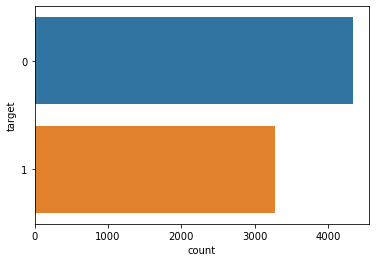

In [43]:
sns.countplot(y=train_df.target);

In [44]:
# we can work with that, their distribution should be good enough, interestingly there is more fakes than real reactions

# now lets analyse the text itself


In [45]:
# helper function 
def create_corpus(target):
    corpus=[]
    
    for x in train_df[train_df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Text(0.5, 1.0, 'TARGET 1: Punctuations')

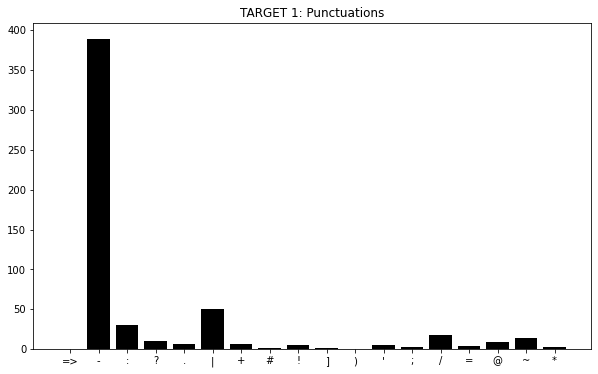

In [46]:
plt.figure(figsize=(10,6))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='black')
plt.title("TARGET 1: Punctuations")

Text(0.5, 1.0, 'TARGET 0: Punctuations')

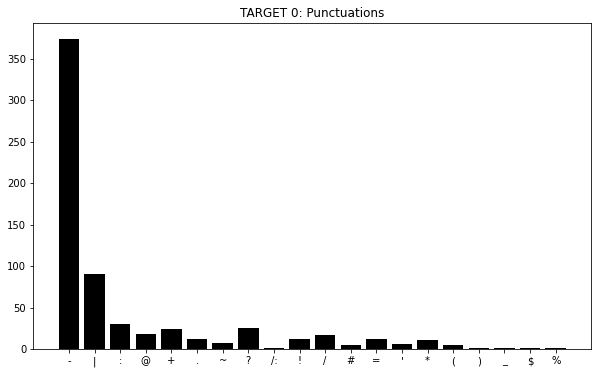

In [47]:
plt.figure(figsize=(10,6))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='black')
plt.title("TARGET 0: Punctuations")

In [48]:
#there are a lot of punctiations in the texts. This is pretty sure caused by twitter mentions, the usage of emoticons etc. ,  so we will delete them in the cleansing process.


# DATA CLEANSING

In [49]:
#first tried this to clean the data, but there was to much 'junk' left, so cleaned the data even more


'''# clean text from noise
def clean_text(text):
    # filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    # remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

train_df['clean_text'] = train_df["text"].apply(clean_text)
test_df['clean_text'] = test_df["text"].apply(clean_text)

train_df.head(20)
test_df.head(20)'''

'# clean text from noise\ndef clean_text(text):\n    # filter to allow only alphabets\n    text = re.sub(r\'[^a-zA-Z\']\', \' \', text)\n    \n    # remove Unicode characters\n    text = re.sub(r\'[^\x00-\x7f]+\', \'\', text)\n    \n    # convert to lowercase to maintain consistency\n    text = text.lower()\n       \n    return text\n\ntrain_df[\'clean_text\'] = train_df["text"].apply(clean_text)\ntest_df[\'clean_text\'] = test_df["text"].apply(clean_text)\n\ntrain_df.head(20)\ntest_df.head(20)'

In [50]:
# i use a basic helper function to delete the irrelevent information like urls, punctuations, html and symbols, emoticons etc. helperfect by: https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers

def clean_tweets(tweet):
    
    #Removes links and non-ASCII characters
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [51]:
#lets apply the functions and remove...

#...urls and links 
train_df["text"] = train_df["text"].apply(lambda x: clean_tweets(x))
test_df["text"] = test_df["text"].apply(lambda x: clean_tweets(x))

#...emoticons and symbols and related stuff 
train_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))

#...punctuations
train_df["text"] = train_df["text"].apply(lambda x: remove_punctuations(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_punctuations(x))

In [52]:
# lets see how it looks now
train_df.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1
5,8,NaN,NaN,# RockyFire Update = > California Hwy . 2...,1
6,10,NaN,NaN,# flood # disaster Heavy rain causes flash f...,1
7,13,NaN,NaN,I ' m on top of the hill and I can see a fire ...,1
8,14,NaN,NaN,There ' s an emergency evacuation happening no...,1
9,15,NaN,NaN,I ' m afraid that the tornado is coming to our...,1


In [53]:
#Actually this step caused a drop in the score by 0.04 so i didn't apply it after the first try 

'''# there are a lot of repetitive characters in the text, lets get rid of them

def rep(text):
    grp = text.group(0)
    if len(grp) > 1:
        return grp[0:1] # can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert'''

"# there are a lot of repetitive characters in the text, lets get rid of them\n\ndef rep(text):\n    grp = text.group(0)\n    if len(grp) > 1:\n        return grp[0:1] # can change the value here on repetition\ndef unique_char(rep,sentence):\n    convert = re.sub(r'(\\w)\x01+', rep, sentence) \n    return convert"

In [54]:
# this is the appliance of the helper function in the step before
'''train_df['text']=train_df['text'].apply(lambda x : unique_char(rep,x))
test_df['text']=test_df['text'].apply(lambda x : unique_char(rep,x))
train_df.head(30)'''

"train_df['text']=train_df['text'].apply(lambda x : unique_char(rep,x))\ntest_df['text']=test_df['text'].apply(lambda x : unique_char(rep,x))\ntrain_df.head(30)"

# BUILDING THE MODEL

In [55]:
# i used a pretrained bert model: bert_en_uncased_L-24_H-1024_A-16/2; found it in another notebook: https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub


def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [56]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0.1:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [57]:

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [58]:
%%time
##there is also a smaller one "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-768_A-12/2", but i decided to go directly for the large model
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 11.2 s, sys: 1.43 s, total: 12.6 s
Wall time: 12.8 s


In [59]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [60]:
train_input = bert_encode(train_df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_df.text.values, tokenizer, max_len=160)
train_labels = train_df.target.values

In [61]:
model = build_model(bert_layer, max_len=160)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

# TRAIN THE MODEL

In [62]:
#the checkpoint callback is used, so it saves the model as a .h5 file, after finishing the training, the model with the lowest validation loss is applied to the test_df.

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)


train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/8
381/381 [==============================] - 430s 1s/step - loss: 0.4670 - accuracy: 0.7833 - val_loss: 0.3904 - val_accuracy: 0.8332
Epoch 2/8
381/381 [==============================] - 389s 1s/step - loss: 0.3542 - accuracy: 0.8504 - val_loss: 0.4174 - val_accuracy: 0.8372
Epoch 3/8
381/381 [==============================] - 389s 1s/step - loss: 0.2858 - accuracy: 0.8844 - val_loss: 0.4595 - val_accuracy: 0.8437
Epoch 4/8
381/381 [==============================] - 389s 1s/step - loss: 0.2276 - accuracy: 0.9099 - val_loss: 0.4713 - val_accuracy: 0.8313
Epoch 5/8
381/381 [==============================] - 389s 1s/step - loss: 0.1810 - accuracy: 0.9274 - val_loss: 0.5456 - val_accuracy: 0.8221
Epoch 6/8
381/381 [==============================] - 389s 1s/step - loss: 0.1404 - accuracy: 0.9475 - val_loss: 0.6635 - val_accuracy: 0.8148
Epoch 7/8
381/381 [==============================] - 389s 1s/step - loss: 0.1047 - accuracy: 0.9614 - val_loss: 0.6205 - val_accuracy: 0.8339
Epoch 

In [63]:

%%time
model.load_weights('model.h5')

CPU times: user 13.1 s, sys: 8.53 s, total: 21.6 s
Wall time: 1min 6s


In [85]:
# import the submission.csv, extract it, apply the as integer rounded predictions for the test data and save it as a new submission.csv

sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
preds =model.predict(test_input, verbose=1)

#round to 0 or 1
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

#convert predicted values from float32 to int
preds=preds.astype('int') 
preds

102/102 [==============================] - 60s 583ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
#insert into the submission table
sub['target'] = preds
sub.to_csv('submission.csv', index=False)

# RESULTS PART 1


1. With Cleasning, 8 Epochs, batchzise: 16, validation split: 0.2, DropOut:  0      = kaggle score: 0.84155 
2. Without Cleansing, 8 Epochs, batchzise: 16, validation split: 0.2, DropOut:  0      = kaggle score: 0.80135
3. With Cleasning, 4 Epochs, batchzise: 16, validation split: 0.2, DropOut:  0      = kaggle score: 0.83849 
4. With Cleasning, 4 Epochs, batchzise: 16, validation split: 0.3, DropOut:  0      = kaggle score: 0.83083
5. With Cleasning, 16 Epochs, batchzise: 16, validation split: 0.2, DropOut:  0      = kaggle score: 0.83358
6. With Cleasning, 8 Epochs, batchzise: 16, validation split: 0.2, DropOut:  0.1      = kaggle score: 0.83450

![](http://)

# PART 2 (1nd in my chronological order but second in this notebook because i got the better keggle score with the other one.)

As i mentioned i started using this model, but resigned after 2 days, because i couldn't get a better score than 0.8271. I wanted to include this but anyways because it took a lot of work.
To run this bit, you have to anable the TCU in the kaggle notebook, uncommend all the parts und comment out all the parts above.

**YOU CAN FIND THE ENDRESULTS FOR THE DIFFERENT PRETRAINED MODELS AT THE END OF THE NOTEBOOKS**

# IMPORTS AND CHECK FOR ACCELERATION UNIT

In [65]:
'''# import the needed packages


import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
from tokenizers import BertWordPieceTokenizer
import os
import re'''

"# import the needed packages\n\n\nimport numpy as np \nimport pandas as pd \npd.set_option('display.max_rows', 100)\npd.set_option('display.max_colwidth', 1000)\n\nimport matplotlib.pyplot as plt\nfrom tensorflow.keras.layers import Dense, Input\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.models import Model\nimport tensorflow as tf\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nimport transformers\nfrom tokenizers import BertWordPieceTokenizer\nimport os\nimport re"

In [67]:
'''#Activate the TPU for faster rendering

AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)'''

'#Activate the TPU for faster rendering\n\nAUTO = tf.data.experimental.AUTOTUNE\n\n# Create strategy from tpu\ntpu = tf.distribute.cluster_resolver.TPUClusterResolver()\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\nstrategy = tf.distribute.experimental.TPUStrategy(tpu)'


# IMPORT THE DATA 


In [66]:
'''# import the datasets directly from kaggle:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


TRAIN_FILE_PATH = '/kaggle/input/nlp-getting-started/train.csv'
TEST_FILE_PATH = '/kaggle/input/nlp-getting-started/test.csv'
SUBMISSION_FILE_PATH = '/kaggle/input/nlp-getting-started/sample_submission.csv'

train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)'''

"# import the datasets directly from kaggle:\n\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n\nTRAIN_FILE_PATH = '/kaggle/input/nlp-getting-started/train.csv'\nTEST_FILE_PATH = '/kaggle/input/nlp-getting-started/test.csv'\nSUBMISSION_FILE_PATH = '/kaggle/input/nlp-getting-started/sample_submission.csv'\n\ntrain_df = pd.read_csv(TRAIN_FILE_PATH)\ntest_df = pd.read_csv(TEST_FILE_PATH)"

# DATA OBSERVATION

I did the same things here i did in part 1, so i didn't copy them down here, because they aren't essential for running the code

# DATA CLEANSING

In [68]:
'''# i use a basic helper function to delete the irrelevent information like urls, punctuations, html and symbols, emoticons etc. helperfect by: https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers

def clean_tweets(tweet):
    
    #Removes links and non-ASCII characters
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text'''

'# i use a basic helper function to delete the irrelevent information like urls, punctuations, html and symbols, emoticons etc. helperfect by: https://www.kaggle.com/datafan07/disaster-tweets-nlp-eda-bert-with-transformers\n\ndef clean_tweets(tweet):\n    \n    #Removes links and non-ASCII characters\n    tweet = \'\'.join([x for x in tweet if x in string.printable])\n    \n    # Removing URLs\n    tweet = re.sub(r"http\\S+", "", tweet)\n    return tweet\n\ndef remove_emoji(text):\n    emoji_pattern = re.compile(\n        \'[\'\n        u\'😀-🙏\'  # emoticons\n        u\'🌀-🗿\'  # symbols & pictographs\n        u\'🚀-\U0001f6ff\'  # transport & map symbols\n        u\'\U0001f1e0-🇿\'  # flags (iOS)\n        u\'✂-➰\'\n        u\'Ⓜ-🉑\'\n        \']+\',\n        flags=re.UNICODE)\n    return emoji_pattern.sub(r\'\', text)\n\n\ndef remove_punctuations(text):\n    punctuations = \'@#!?+&*[]-%.:/();$=><|{}^\' + "\'`"\n    \n    for p in punctuations:\n        text = text.replace(p, f\' {p} \')\n

In [69]:
'''#lets remove...

#...urls and links 
train_df["text"] = train_df["text"].apply(lambda x: clean_tweets(x))
test_df["text"] = test_df["text"].apply(lambda x: clean_tweets(x))

#...emoticons and symbols and related stuff 
train_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))

#...punctuations
train_df["text"] = train_df["text"].apply(lambda x: remove_punctuations(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_punctuations(x))'''

'#lets remove...\n\n#...urls and links \ntrain_df["text"] = train_df["text"].apply(lambda x: clean_tweets(x))\ntest_df["text"] = test_df["text"].apply(lambda x: clean_tweets(x))\n\n#...emoticons and symbols and related stuff \ntrain_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))\ntest_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))\n\n#...punctuations\ntrain_df["text"] = train_df["text"].apply(lambda x: remove_punctuations(x))\ntest_df["text"] = test_df["text"].apply(lambda x: remove_punctuations(x))'

# BUILDING THE MODEL

In [70]:
'''# the model i used i got from: http://education.abcom.com/detecting-slang-using-bert/ 

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)'''

'# the model i used i got from: http://education.abcom.com/detecting-slang-using-bert/ \n\ndef fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):\n    tokenizer.enable_truncation(max_length=maxlen)\n    tokenizer.enable_padding(max_length=maxlen)\n    all_ids = []\n    \n    for i in tqdm(range(0, len(texts), chunk_size)):\n        text_chunk = texts[i:i+chunk_size].tolist()\n        encs = tokenizer.encode_batch(text_chunk)\n        all_ids.extend([enc.ids for enc in encs])\n    \n    return np.array(all_ids)'

In [71]:
'''def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model'''

'def build_model(transformer, loss=\'binary_crossentropy\', max_len=512):\n    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")\n    sequence_output = transformer(input_word_ids)[0]\n    cls_token = sequence_output[:, 0, :]\n    x = tf.keras.layers.Dropout(0.35)(cls_token)\n    out = Dense(1, activation=\'sigmoid\')(x)\n    \n    model = Model(inputs=input_word_ids, outputs=out)\n    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])\n    \n    return model'

In [72]:
'''# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-cased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=False)
fast_tokenizer'''

"# First load the real tokenizer\ntokenizer = transformers.BertTokenizer.from_pretrained('bert-large-cased')\n\n# Save the loaded tokenizer locally\nsave_path = '/kaggle/working/distilbert_base_uncased/'\nif not os.path.exists(save_path):\n    os.makedirs(save_path)\ntokenizer.save_pretrained(save_path)\n\n# Reload it with the huggingface tokenizers library\nfast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=False)\nfast_tokenizer"

# HYPERPARAMETERS

In [73]:
'''# Hyperparameter

#all in one place so we can change them faster

MAX_LEN = 160 
EPOCHS = 8
BATCH_SIZE = 16 
STBS=150'''

'# Hyperparameter\n\n#all in one place so we can change them faster\n\nMAX_LEN = 160 \nEPOCHS = 8\nBATCH_SIZE = 16 \nSTBS=150'

In [74]:
'''#lets split the data set

train_df, valid_df = train_test_split(train_df, test_size=0.2)'''

'#lets split the data set\n\ntrain_df, valid_df = train_test_split(train_df, test_size=0.2)'

In [75]:
'''# and apply them to the model

x_train = fast_encode(train_df.text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid_df.text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test_df.text.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train_df.target.values
y_valid = valid_df.target.values'''

'# and apply them to the model\n\nx_train = fast_encode(train_df.text.astype(str), fast_tokenizer, maxlen=MAX_LEN)\nx_valid = fast_encode(valid_df.text.astype(str), fast_tokenizer, maxlen=MAX_LEN)\nx_test = fast_encode(test_df.text.astype(str), fast_tokenizer, maxlen=MAX_LEN)\n\ny_train = train_df.target.values\ny_valid = valid_df.target.values'

In [76]:
'''

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)'''

'\n\ntrain_dataset = (\n    tf.data.Dataset\n    .from_tensor_slices((x_train, y_train))\n    .repeat()\n    .shuffle(2048)\n    .batch(BATCH_SIZE)\n    .prefetch(AUTO)\n)\n\nvalid_dataset = (\n    tf.data.Dataset\n    .from_tensor_slices((x_valid, y_valid))\n    .batch(BATCH_SIZE)\n    .cache()\n    .prefetch(AUTO)\n)\n\ntest_dataset = (\n    tf.data.Dataset\n    .from_tensor_slices(x_test)\n    .batch(BATCH_SIZE)\n)'

In [77]:
'''# i used a LearningRateScheduler to optimize the time needed for training 

def build_lrfn(lr_start=1e-6, lr_max=2e-6, 
               lr_min=1e-7, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.9):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn


#PLot the funktion
plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(40)], [_lrfn(i) for i in range(40)]);'''

'# i used a LearningRateScheduler to optimize the time needed for training \n\ndef build_lrfn(lr_start=1e-6, lr_max=2e-6, \n               lr_min=1e-7, lr_rampup_epochs=7, \n               lr_sustain_epochs=0, lr_exp_decay=.9):\n    lr_max = lr_max * strategy.num_replicas_in_sync\n\n    def lrfn(epoch):\n        if epoch < lr_rampup_epochs:\n            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start\n        elif epoch < lr_rampup_epochs + lr_sustain_epochs:\n            lr = lr_max\n        else:\n            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min\n        return lr\n    \n    return lrfn\n\n\n#PLot the funktion\nplt.figure(figsize=(10, 7))\n\n_lrfn = build_lrfn()\nplt.plot([i for i in range(40)], [_lrfn(i) for i in range(40)]);'

In [78]:
'''# The newly introduced focal loss function is created specifically to deal with the data imbalance problem for one-staged detectors. It improves training.
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed'''

'# The newly introduced focal loss function is created specifically to deal with the data imbalance problem for one-staged detectors. It improves training.\nfrom tensorflow.keras import backend as K\n\ndef focal_loss(gamma=2., alpha=.2):\n    def focal_loss_fixed(y_true, y_pred):\n        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))\n        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))\n        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))\n    return focal_loss_fixed'

In [79]:
'''%%time

# here i changed the pretrained models a lot ( )

with strategy.scope():
    transformer_layer = (
        transformers.TFBertModel.from_pretrained('bert-large-cased')
    )
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=MAX_LEN)
model.summary()'''

"%%time\n\n# here i changed the pretrained models a lot ( )\n\nwith strategy.scope():\n    transformer_layer = (\n        transformers.TFBertModel.from_pretrained('bert-large-cased')\n    )\n    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=MAX_LEN)\nmodel.summary()"

# TRAIN THE MODEL

In [80]:
'''#i also used a earlystop callback, but it wasn't that effective and made the kaggle score worse so i commented it out



# from keras.callbacks import EarlyStopping
lrfn = build_lrfn()
lrs = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
# earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=STBS,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lrs],
)'''

"#i also used a earlystop callback, but it wasn't that effective and made the kaggle score worse so i commented it out\n\n\n\n# from keras.callbacks import EarlyStopping\nlrfn = build_lrfn()\nlrs = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)\n# earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)\n\ntrain_history = model.fit(\n    train_dataset,\n    steps_per_epoch=STBS,\n    validation_data=valid_dataset,\n    epochs=EPOCHS,\n    batch_size=BATCH_SIZE,\n    callbacks=[lrs],\n)"

In [81]:
'''
#apply model to submission dataset 
sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
preds =model.predict(test_dataset, verbose=1)

#round to 0 or 1
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

#convert predicted values from float32 to int
preds=preds.astype('int') 
preds

'''

"\n#apply model to submission dataset \nsub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')\npreds =model.predict(test_dataset, verbose=1)\n\n#round to 0 or 1\npreds[preds >= 0.5] = 1\npreds[preds < 0.5] = 0\n\n#convert predicted values from float32 to int\npreds=preds.astype('int') \npreds\n\n"

In [82]:
'''#insert into the submission table
sub['target'] = preds
sub.to_csv('submission.csv', index=False)

'''

"#insert into the submission table\nsub['target'] = preds\nsub.to_csv('submission.csv', index=False)\n\n"

# RESULTS PART 2

Strangly the accuracies, val. accuracies and validation losses are a lot better with this models, but somehow the kaggle score stays unter 0.8271.

Some examples from the best run with every pretrained model:

* destilBERT: 0.75268 (data cleaned; can't remember the hyperparameters)
* bert-base-cased: 0.85000 (data cleaned; can't remember the hyperparameters)
* bert-large-cased-whole-word-masking-finetuned-squad: 0.82715 (strangly without data cleaning; Batchsize: 64, Steps: 100, Epochs: 4,  max_len: 160)
* bert-large-uncased: 0.82562 (with data cleaning; Batchsize: 16, Steps: 150, Epochs: 8, max_len: 160)

# OVERALL CONCLUSION

First of all: the challenge was very interesting. Since I had not worked with NLPs in the labs before, it was a special challenge. Therefore it was helpful to partly use existing solutions like the pre-trained BERT models and to be able to view notebooks of other participants of the challenge. However, I did not get very clever with my results from Part 2. As already mentioned I applied this model first and tested nearly 50 different combinations of models and hyperparameters. Even though the values of the model (validation accuracy, validation loss, and accuracy) were extremely good, the best score I could get was only 0.8271. The only advantage of these models was that they were relatively fast to calculate even with a large number of steps. 

The bert_en_uncased_L-24_H-1024_A-16/2 model, on the other hand, took much longer (sometimes 20 times longer), but also gave a better Kaggle Score. However, the values (validation accuracy, validation loss, and accuracy ) of the calculated models were a bit worse.